In [6]:
## Imports

# We'll need numpy for some mathematical operations
import numpy as np
import math

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import glob
import os

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

import random

# Import local modules
from helpers import *

In [2]:
## Load all sample files
filedir = "/Volumes/External Storage/Thesis/Corpus/eng-balm-emmanuel/flac" #"../testSounds" 
segment_length = 0.2  # length of segments in seconds

sounds, samplerates = load_sounds(filedir)
spectrograms, mfccs, rmss, centroids, max_num_segs = analyze_sounds(sounds, samplerates, segment_length)

num_files = len(sounds)

directory = '/Users/aaronkarp/Documents/Thesis/Code/savedData/'
to_save = [['samplerates', samplerates], ['spectrograms', spectrograms], ['mfccs', mfccs], ['rmss', rmss], ['centroids', centroids]]
save_data(to_save, directory)

Loading...
1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     23%     24%     25%     26%     27%     28%     29%     30%     31%     32%     33%     34%     35%     36%     37%     38%     39%     40%     41%     42%     43%     44%     45%     46%     47%     48%     49%     50%     51%     52%     53%     54%     55%     56%     57%     58%     59%     60%     61%     62%     63%     64%     65%     66%     67%     68%     69%     70%     71%     72%     73%     74%     75%     76%     77%     78%     79%     80%     81%     82%     83%     84%     85%     86%     87%     88%     89%     90%     91%     92%     93%     94%     95%     96%     97%     98%     99%     100%     Finished Loading
Analyzing...
1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     

In [3]:
## Organize features into lists of segments
# feature1 = [segment1 segment2 segment3]
# segment1 = nxm np.matrix 
        
spectrograms_by_seg, spectrograms_by_seg_flat = segment_spectrograms(spectrograms, max_num_segs, num_files)

In [4]:
## Build LSHs for spectrograms_by_seg
engines = []
num_bits = 40 # How many bits to use for hashing
for seg in spectrograms_by_seg_flat:
    engines.append(build_lsh(seg, num_bits))

Original query: eng-0a1139f9.flac


Best guess: 739


Second best guess: 527


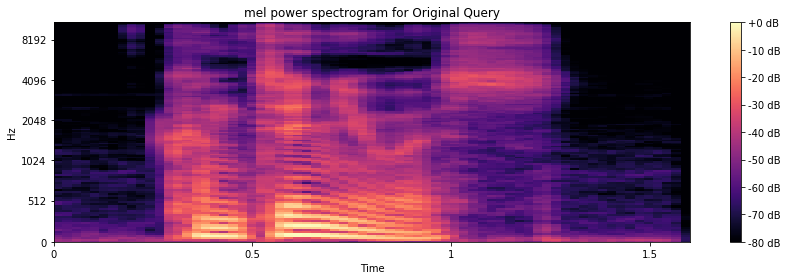

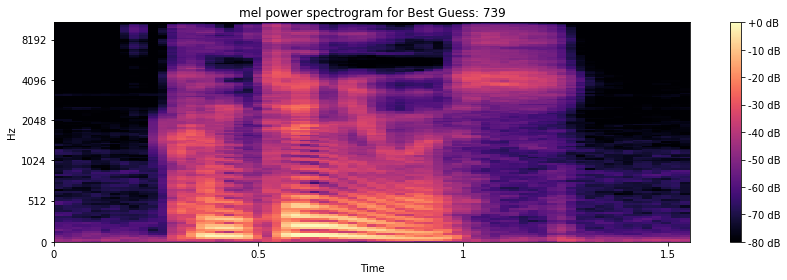

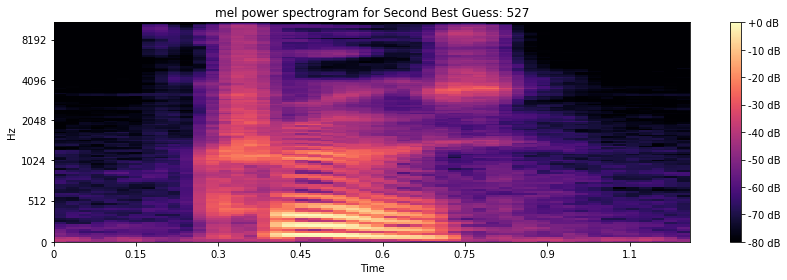

Guesses: 739 : 8.881784197001252e-16
527 : 0.005238302207959733
75 : 0.012165101295506853
801 : 0.01221960910115405
256 : 0.016233645656346773


In [8]:
## Query

# Choose random sound in directory
os.chdir("/Users/aaronkarp/Documents/Thesis/testSounds")
files = []
files.extend(glob.glob("*.wav"))
files.extend(glob.glob("*.flac"))

guesses, distances = query_sound(random.choice(files), engines, num_files, sounds, samplerates, display=True)
print("Guesses: ", end='')

for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))